In [1]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from flask import Flask, request, jsonify

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load dataset
df = pd.read_csv("Ulasan.csv")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

In [4]:
# Preprocess dataset
df = df.dropna(subset=['reviews.text', 'reviews.rating'])
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'positive' if x > 3 else 'negative')
df['cleaned_review'] = df['reviews.text'].apply(preprocess_text)

<ipython-input-4-ab12a45f5151>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['reviews.rating'].apply(lambda x: 'positive' if x > 3 else 'negative')


In [5]:
# Split dataset
X = df['cleaned_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [7]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

best_model = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

Logistic Regression Accuracy: 0.8771
              precision    recall  f1-score   support

    negative       1.00      0.19      0.33        36
    positive       0.87      1.00      0.93       200

    accuracy                           0.88       236
   macro avg       0.94      0.60      0.63       236
weighted avg       0.89      0.88      0.84       236

Naïve Bayes Accuracy: 0.8729
              precision    recall  f1-score   support

    negative       1.00      0.17      0.29        36
    positive       0.87      1.00      0.93       200

    accuracy                           0.87       236
   macro avg       0.93      0.58      0.61       236
weighted avg       0.89      0.87      0.83       236

Random Forest Accuracy: 0.8898
              precision    recall  f1-score   support

    negative       0.75      0.42      0.54        36
    positive       0.90      0.97      0.94       200

    accuracy                           0.89       236
   macro avg       0.83      0.

<ipython-input-8-8b0a81e04ef8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


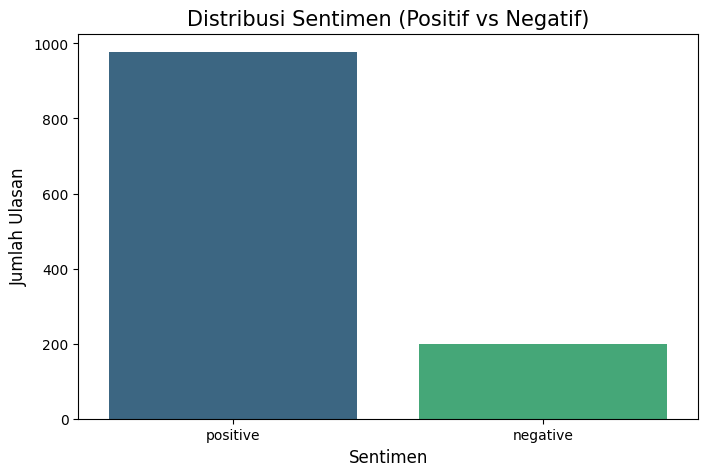

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Sentimen (Positif vs Negatif)', fontsize=15)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

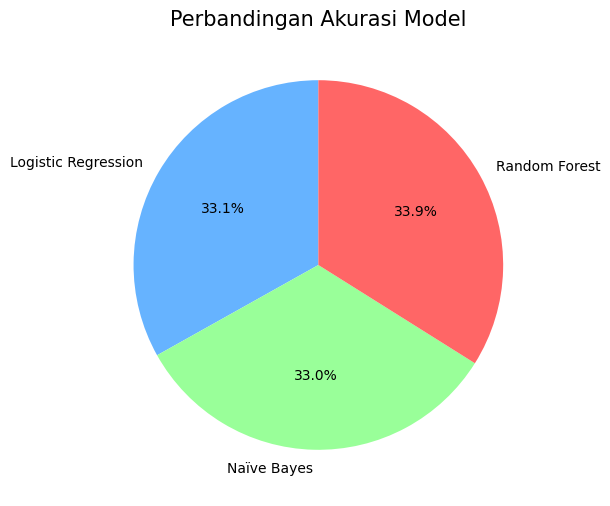

In [9]:
# Akurasi per model
accuracy_dict = {
    "Logistic Regression": accuracy_score(y_test, LogisticRegression().fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
    "Naïve Bayes": accuracy_score(y_test, MultinomialNB().fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
    "Random Forest": accuracy_score(y_test, RandomForestClassifier().fit(X_train_tfidf, y_train).predict(X_test_tfidf))
}

# Plot perbandingan akurasi model menggunakan pie chart
plt.figure(figsize=(8, 6))
plt.pie(accuracy_dict.values(), labels=accuracy_dict.keys(), autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'])
plt.title('Perbandingan Akurasi Model', fontsize=15)
plt.show()

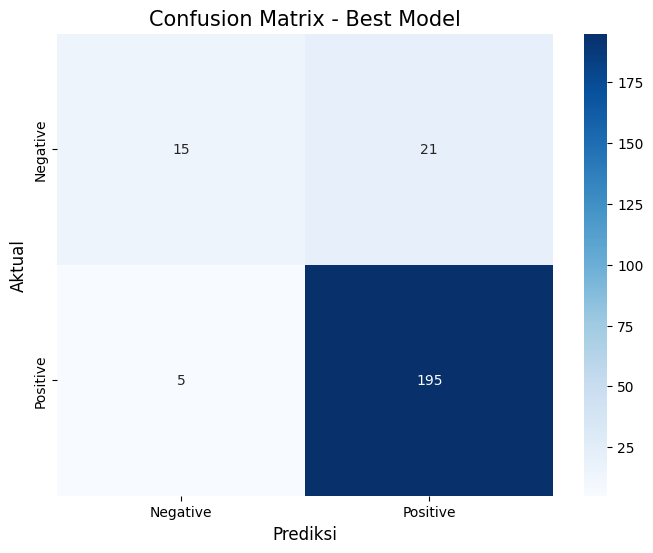

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix untuk model terbaik
y_pred_best_model = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Model', fontsize=15)
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.show()

<ipython-input-11-9d8b6795e9c3>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(precision_dict.keys()), y=list(precision_dict.values()), palette='Blues', ax=axes[0])
<ipython-input-11-9d8b6795e9c3>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(recall_dict.keys()), y=list(recall_dict.values()), palette='Greens', ax=axes[1])
<ipython-input-11-9d8b6795e9c3>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_dict.keys()), y=list(f1_dict.values()), palette='Oranges', ax=axes[2])


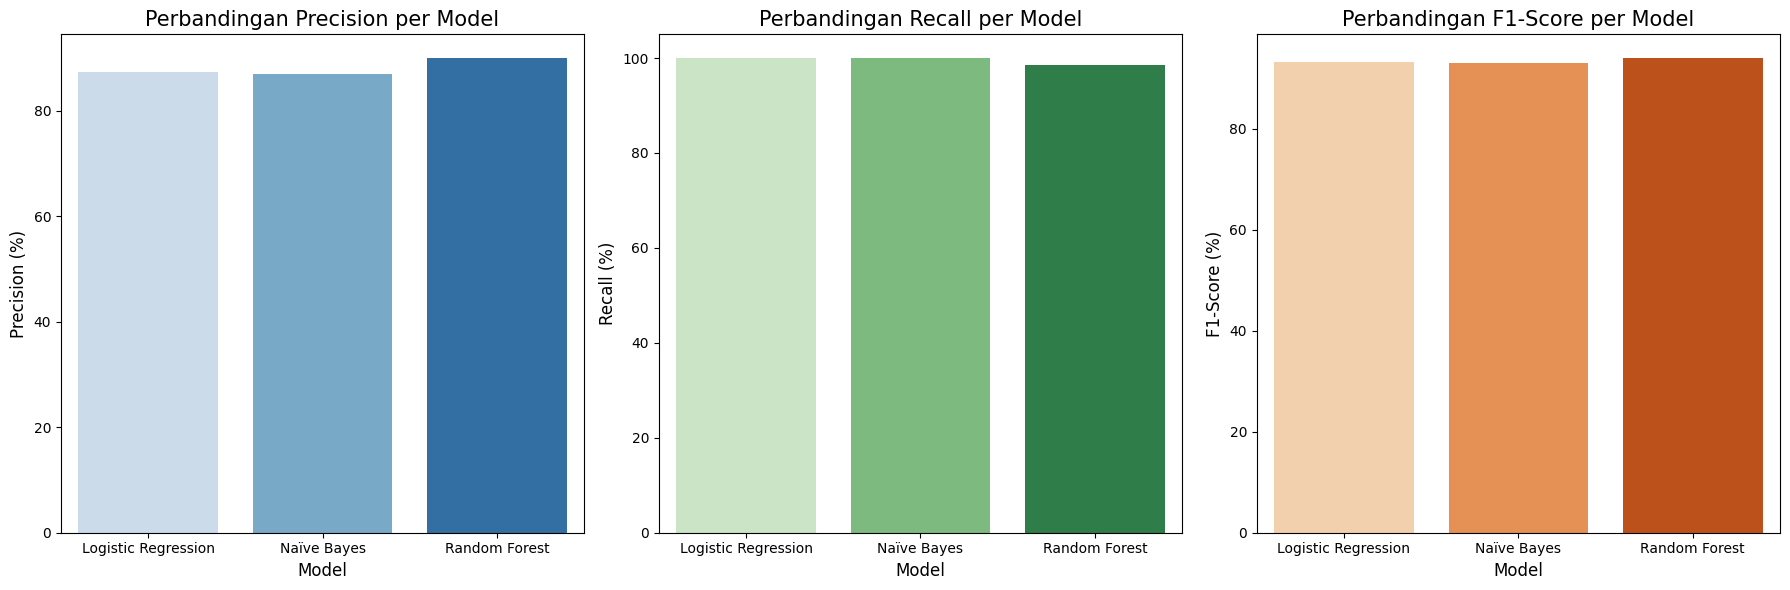

In [11]:
# Menghitung Precision, Recall, dan F1-Score per model
from sklearn.metrics import precision_score, recall_score, f1_score

precision_dict = {}
recall_dict = {}
f1_dict = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    precision = precision_score(y_test, y_pred, pos_label='positive')
    recall = recall_score(y_test, y_pred, pos_label='positive')
    f1 = f1_score(y_test, y_pred, pos_label='positive')

    precision_dict[name] = precision * 100  # Mengubah menjadi persentase
    recall_dict[name] = recall * 100  # Mengubah menjadi persentase
    f1_dict[name] = f1 * 100  # Mengubah menjadi persentase

# Setup untuk subplot horizontal
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Precision per Model
sns.barplot(x=list(precision_dict.keys()), y=list(precision_dict.values()), palette='Blues', ax=axes[0])
axes[0].set_title('Perbandingan Precision per Model', fontsize=15)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Precision (%)', fontsize=12)

# Plot Recall per Model
sns.barplot(x=list(recall_dict.keys()), y=list(recall_dict.values()), palette='Greens', ax=axes[1])
axes[1].set_title('Perbandingan Recall per Model', fontsize=15)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Recall (%)', fontsize=12)

# Plot F1-Score per Model
sns.barplot(x=list(f1_dict.keys()), y=list(f1_dict.values()), palette='Oranges', ax=axes[2])
axes[2].set_title('Perbandingan F1-Score per Model', fontsize=15)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('F1-Score (%)', fontsize=12)

# Menampilkan plot
plt.tight_layout()
plt.show()

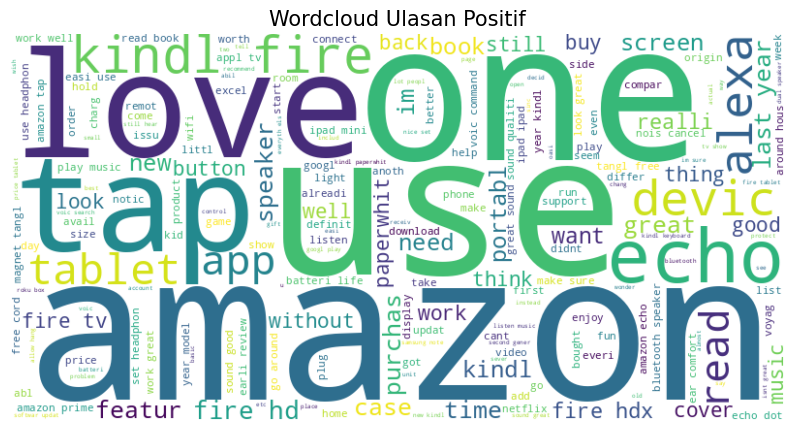

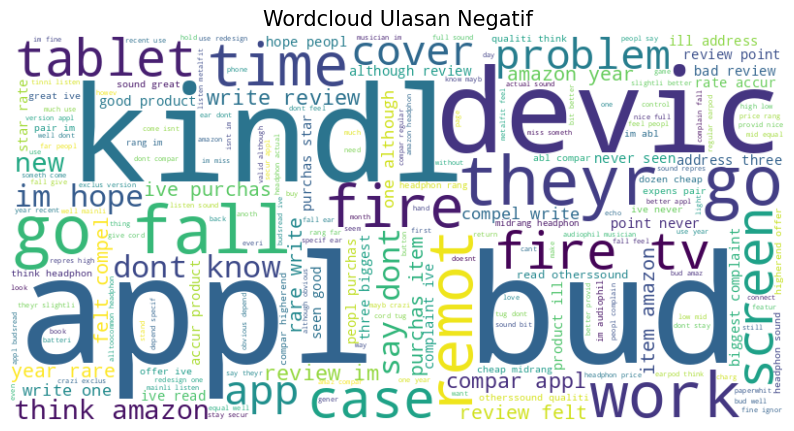

In [12]:
from wordcloud import WordCloud

# Gabungkan teks positif dan negatif
positive_reviews = " ".join(df[df['sentiment'] == 'positive']['cleaned_review'])
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['cleaned_review'])

# Generate wordcloud untuk ulasan positif
plt.figure(figsize=(10, 6))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Wordcloud Ulasan Positif', fontsize=15)
plt.axis('off')
plt.show()

# Generate wordcloud untuk ulasan negatif
plt.figure(figsize=(10, 6))
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Wordcloud Ulasan Negatif', fontsize=15)
plt.axis('off')
plt.show()

In [13]:
# Save best model and vectorizer
joblib.dump(best_model, "best_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [14]:
# Flask API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    review = data.get("review", "")

    if not review:
        return jsonify({"error": "Input tidak valid. Harap masukkan teks ulasan."}), 400

    processed_review = preprocess_text(review)
    transformed_review = tfidf.transform([processed_review])
    prediction = best_model.predict(transformed_review)[0]

    return jsonify({"review": review, "sentiment": prediction})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
